$$\text{Stacking}$$

#### What is Stacking?

> "A scheme of minimizing the generalization error rate of one or more generalizers. Stacked generalization works by deducing the biases of the generalizers with repsect to a provided learning set. This deduction proceeds by generalizing in a second space whose inputs are the gusses of the original generalizers...and whose input is the correct guess." - *Wolpert David H.*

> Stacking is the process of using the predictions of multiple machine learning models as the inputs of another model. When done correctly it can minimize the bias of the individual input models with respect to the training data and produce a an aggregated model that does a better job of generalizing to unseen data. For this reason it is aa very popular technique among data science competition winners.  - *IBM*

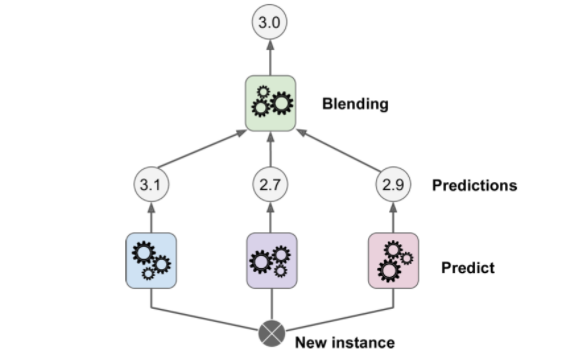

> It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation? Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a blender, or a meta learner) takes these predictions as inputs and makes the final prediction (3.0). - *Hands-on Machine Learning*

***Stacking uses a meta learning algorithm to take predictions from multiple well-performed machine learning algorithms as input and produces an aggregated model that does a better job of generalizing the information about unseen data.***

When we find multiple machine learning algoritgms perform well and in different ways on the same dataset, which model should we trust? Stacking is just an ensemble technique that allows us to harness the capabilities of these models and generates an aggregated model that performs better than any single model.

***Note: these predictions made by first-layer models should be uncorrelated so that aggregating them can reduce the error rate.***

#### Why is Stacked Ensemble Important?

> "They have been proven to be effective at producing models with less variance without significantly increasing the bias."

1. Model stacking is used among competition winners and practitioners, and is simple. Your meta-learner generalizes better than a single model. That is, it makes better predictions on unseen data than just a single model.  Stacked Ensembles have won several data science contests:
    - Netflix $1M prize. BellKor's Pragmatic Chaos used a blend of 100's of different models.
    - Kaggle - Otto group Product Classification Challenge. The winning team used a stacked ensemble of 33 models at the first level.
    - KDDCUP 2015. Winning entry used a stacked ensemble of 64 models at the first level.
2. A good paper on this topic is Stacked Generalization by David H. Wolpert). Wolpert argues that model stacking deduces the bias in a model on a particular data set so that we later can correct for the bias in a meta-learner.
3. Before model stacking became popular and more widely used, a technique called Bayes Model Averaging (BMA) existed. In this model, weights were the posterior probabilities of models. However, empirical evidence by Bertrand Clarke has shown that model stacking with cross validation out performs BMA, while being robust because model stacking is less sensitive to changes in a data set.

#### How Stacking Works?

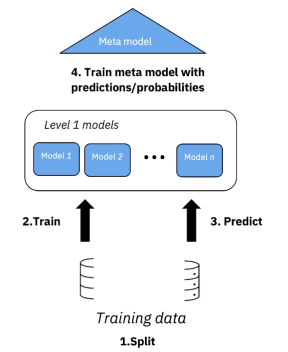

- Split the train set into two halves.
- Train Level 1 models on the half of the training data.
- Run the other half of unseen data through trained level 1 models.
- Use predictions or probabilities to train meta model.
- Train each level 1 model on entire training set for scoring.

Basically, we first split the data into two subsets, and then we use the first subset to train the predictors in the first layer. The first-layer predictors are used to make predictions on the second set(held-out). Now for each instance in the held-out set, we have multiple predicted values from these models. We can create a new training set using these predicted values as input features. The meta model is training on the new set and learns to predict the target value given the predictions of first-layer model.

Also, we are able to create different blenders in this way. For example, Otto Group Product Classification Challener winner creates three different meta learners using the predictions of first-layer models, just as the picture below shows:

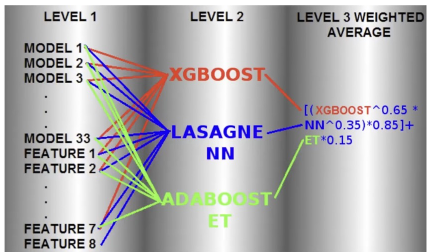


#### Stacked Ensembles Tips

1. We could get better results if:
    - Our level 1 models perform reasonably well
    - Our level 1 models are as different as possible. This means that the predictions made by these models or errors in predictions are uncorrelated.

2. **The option of base models should be complex and diverse.** It is usually a good idea to try a set of models that make different assumptions on dataset, such as linear models, tree-based models, support vector machine, and neutral networks.

3. **The meta-model is often simple, providing a smooth interpretation of the predictions made by the base models.** As such, linear models are often used as the meta-model, such as linear regression for regression tasks (predicting a numeric value) and logistic regression for classification tasks (predicting a class label). Although this is common, it is not required.

4. For classification try using **probabilities** instead of predictions for inputs to the meta learners

5. Always create a simple implementation and use it as a point of comparison with our K-fold implementation

6. Treat our level 1 models as hyperparameters to allow for automation

#### Lab 

In this section, we will build a stacked ensemble model in practice using the dataset of *Titantic Survival Prediction* from kaggle. Scikit-learn package has a built-in function `StackingClassifier` that helps us to implement the stacking without coding manaully.

##### Step 1: Split Data into Two Subsets

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

%matplotlib inline

# make a classification dataset
X,y = make_classification(n_samples=10000,n_features=30,n_informative=15,
                   n_redundant=5,random_state=1)

# split the dataset into two subsets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

# split the train set into havles
X_train_first_half,X_train_second_half,y_train_first_half,y_train_second_half= train_test_split(X_train,y_train,train_size=0.5,test_size=0.5,random_state=1)
print(X_train_first_half.shape,X_train_second_half.shape,y_train_first_half.shape,y_train_second_half.shape)

(8000, 30) (8000,) (2000, 30) (2000,)
(4000, 30) (4000, 30) (4000,) (4000,)


##### Create First-layer Models & Meta Model

Train the model on the first half of training data and generate the predictions using the second half.

Note: The function `predict_proba()` returns a numpy array of two columns. The first column is the probability that target=0 and the second column is the probability that target=1 .

In [36]:
# create an object storing the stacked ensemble model
df_simple_stacked_ensemble_train = pd.DataFrame()
# create model
gbc = GradientBoostingClassifier(random_state=42,learning_rate=0.01)
# train model on the first half of training data
gb_model = gbc.fit(X_train_first_half,y_train_first_half)
# Generate probabilities using the second half of training data as the input
y_train_prob = gb_model.predict_proba(X_train_second_half)[:,1]
df_simple_stacked_ensemble_train['gb'] = y_train_prob.tolist()

Retrain on all training data and generate probabilities to test the simple Stacked Ensemble.

In [37]:
df_simple_stacked_ensemble_test = pd.DataFrame()
# retrain model on all training data
gb_model = gbc.fit(X_train,y_train)

# generate probabilities for test data
y_test_prob = gb_model.predict_proba(X_test)[:,1]
df_simple_stacked_ensemble_test['gb'] = y_test_prob.tolist()

Evaluate Gradient Boosting for comparing it with Stacked Ensemble

In [20]:
from sklearn.model_selection import cross_val_score

gb_cv_scores = cross_val_score(gb_model,X_test,y_test,scoring='accuracy',cv=5)
print("Gradient Boosting Accuracy: %.3f (%.3f)"% (np.mean(gb_cv_scores),(np.std(gb_cv_scores))))

Gradient Boosting Accuracy: 0.828 (0.016)


Create the Random Forest Level 1 Model

In [38]:
rf_clf = RandomForestClassifier(random_state=42,max_features="log2")
# fit the model
rf_clf_model = rf_clf.fit(X_train_first_half,y_train_first_half)
# generate predictions
y_train_prob = rf_clf_model.predict_proba(X_train_second_half)[:,1]
df_simple_stacked_ensemble_train['rf'] = y_train_prob.tolist()

In [39]:
# retrain model on all training data
rf_model = rf_clf.fit(X_train,y_train)

# generate probabilities for test data
y_test_prob = rf_model.predict_proba(X_test)[:,1]
df_simple_stacked_ensemble_test['rf'] = y_test_prob.tolist()

In [40]:
rf_cv_scores = cross_val_score(rf_clf,X_test,y_test,scoring='accuracy',cv=5)
print("Random Forest Accuracy: %.3f (%.3f)"% (np.mean(rf_cv_scores),(np.std(rf_cv_scores))))

Random Forest Accuracy: 0.903 (0.009)


##### Create the Meta Model

In [41]:
# Check training probabilities generated by level 1 model
display(df_simple_stacked_ensemble_train.head(5))

,gb,rf
0,0.674670,0.84
1,0.720023,0.81
2,0.641503,0.88
3,0.758390,0.99
4,0.567606,0.62


In [43]:
# check testing probabilities generated by level 1 models
display(df_simple_stacked_ensemble_test.head(5))

,gb,rf
0,0.567687,0.59
1,0.595021,0.59
2,0.744310,0.89
3,0.234321,0.07
4,0.577842,0.70


In [45]:
meta_model = LogisticRegression(random_state=42)
# use the prediction generated by model trained on first train set as input
# use the y actual value of the second half as the output
ensemble_model = meta_model.fit(df_simple_stacked_ensemble_train,y_train_second_half)

Evaluate the meta model using test data

In [47]:
ensemble_cv_scores = cross_val_score(meta_model,df_simple_stacked_ensemble_test,y_test,cv=5,scoring='accuracy')
print("Ensemble Accuracy: %.3f (%.3f)"% (np.mean(ensemble_cv_scores),(np.std(ensemble_cv_scores))))

Ensemble Accuracy: 0.936 (0.006)


**Create Meta Model using K-fold Cross Validation**

In [52]:
# Set up the level 1 models
ensemble2_level1_models = []
ensemble2_level1_models.append(("Gradient Boosting",GradientBoostingClassifier(random_state=42,learning_rate=0.01)))
ensemble2_level1_models.append(('Randon Forest',RandomForestClassifier(random_state=42,max_features="log2")))

In [56]:
from sklearn.model_selection import StratifiedKFold

# create the meta learner
lg_clf = LogisticRegression(random_state=42)
cross_validator = StratifiedKFold(n_splits=10)
ensemble2_model = StackingClassifier(estimators=ensemble2_level1_models,stack_method='predict_proba',
                                     cv=cross_validator,final_estimator=lg_clf)

# fit the model
ensemble2_model.fit(X_train,y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=10,
        random_state=RandomState(MT19937) at 0x7FE4383F6240, shuffle=False),
                   estimators=[('Gradient Boosting',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           random_state=42)),
                               ('Randon Forest',
                                RandomForestClassifier(max_features='log2',
                                                       random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   stack_method='predict_proba')

Evaluate the Meta Model using test data

In [61]:
from sklearn.metrics import accuracy_score

y_pred = ensemble2_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
print("Accuracy: %.3f" % score)

Accuracy: 0.943


##### Summary


Let's plot the accuracy of these different to more clearly compare their performance. 

In [78]:
import plotly.express as px

models = ["Gradient Boosting","Random Forest","Simple Meta odel","K-Fold Meta Model"]
scores = [0.828,0.903,0.936,0.943]
result = pd.DataFrame({"Model":models,"Scores":scores})

# visualisation
fig = px.bar(result,x='Model',y="Scores",color="Model")
fig.update_yaxes(tick0=0.5,dtick=0.1)
fig.show()

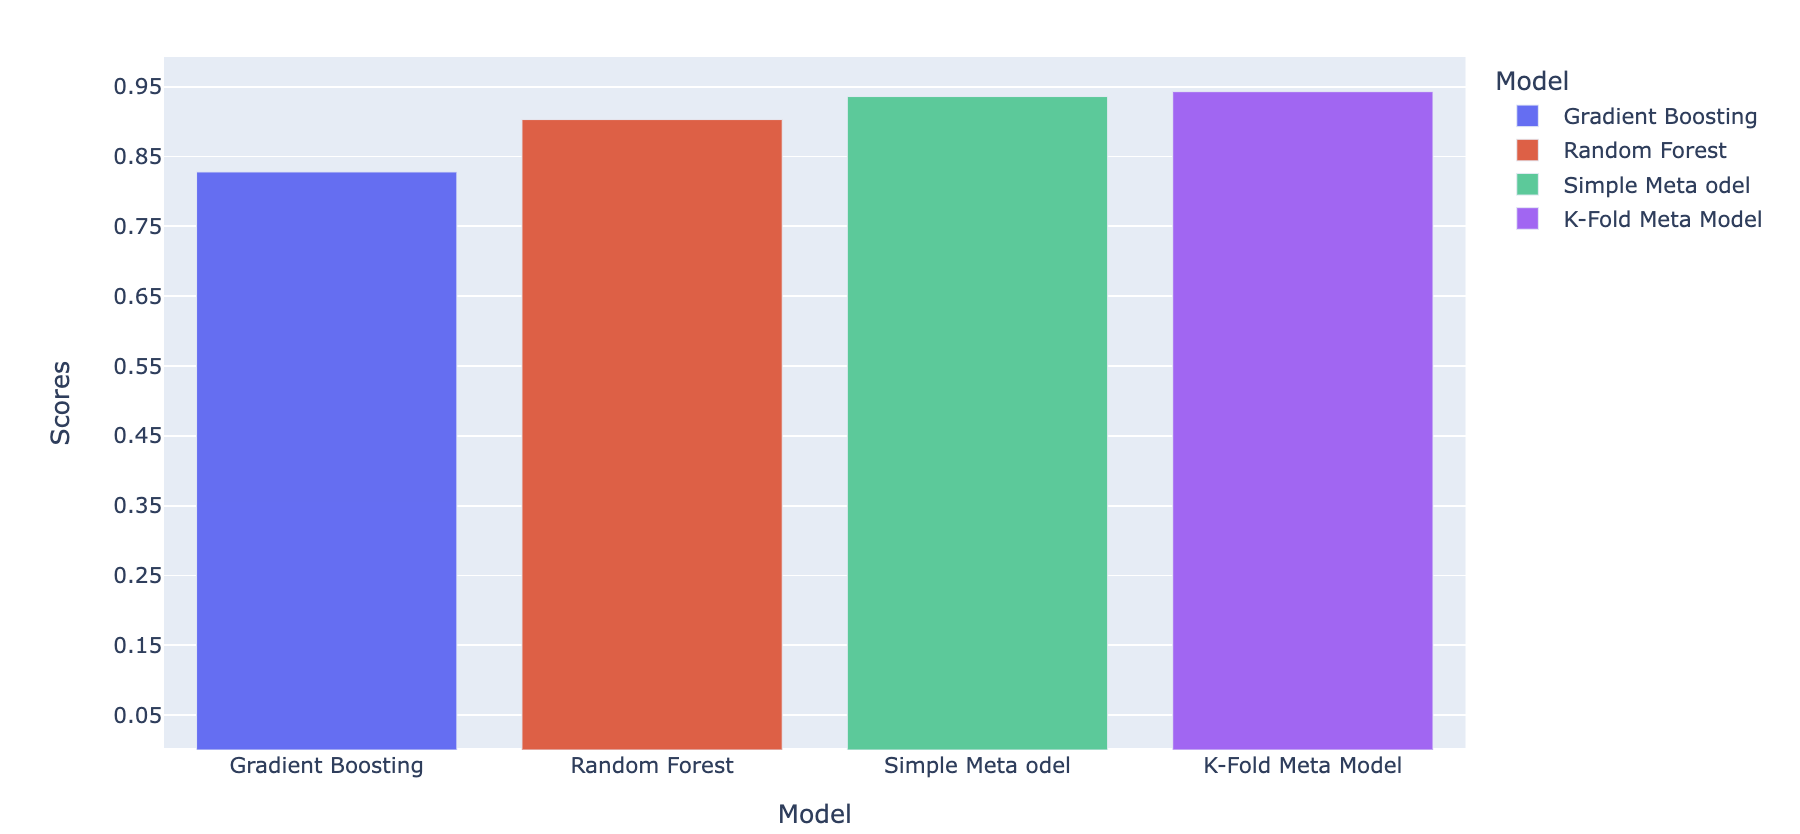